In [1]:
import numpy as np
import scipy.signal as signal
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt

# Inputs
nx = 256
ny = 256
nz = 64
date = 20221230
bc = ''  # Boundary condition
notes = '(SSTSTEADY)'
day = [0, 100]  # Days for pre-aggregation

# Constants
Cp = 1004  # Specific heat at constant pressure (J/kg/K)
g = 9.81  # Acceleration due to gravity (m/s^2)
Lf = 0.3336e+06  # Latent heat of fusion (J/kg)
Ls = 2.8440e+06  # Latent heat of sublimation (J/kg)
Lv = Ls - Lf  # Latent heat of vaporization (J/kg)

# Locate nc files
job = 'SAM6108_RCE_MC_%8.8d_%3.3dx%3.3d' % (date, nx, ny) + str(bc)
path = '/fs3/group/mullegrp/Bidyut_Goswami/sam_data/' + job + '/OUT_' + job + '/NETCDF_files/'

In [2]:
fid = path + 'RCE_MC_' + job + '.nc'
fid

'/fs3/group/mullegrp/Bidyut_Goswami/sam_data/SAM6108_RCE_MC_20221230_256x256/OUT_SAM6108_RCE_MC_20221230_256x256/NETCDF_files/RCE_MC_SAM6108_RCE_MC_20221230_256x256.nc'

In [3]:
# Read 1D nc files
fid = path + 'RCE_MC_' + job + '.nc'
f_totrho = xr.open_dataset(fid)
totrho = f_totrho['RHO']

In [4]:
# Read 2D nc files
totMSE = []
for i in np.arange(1, 4, 1):
    fid = path + 'RCE_MC_' + job + '_' + str(nz) + '.2Dcom_%1d.nc' % i
    tt = xr.open_dataset(fid)
    totMSE.append(tt['MSE'])
totMSE = xr.concat(totMSE, dim='time')


In [5]:
# Read 3D nc files using Dask
W = []
TABS = []
QV = []
for i in range(len(day) - 1):  # Corrected loop index
    timestep = np.arange(1080 * 8 * (day[i]), 1080 * 8 * (day[i+1]) + 1, 1080)[1:]
    for t in timestep:
        fid = path + 'RCE_MC_' + job + '_' + str(nz) + '_%10.10d.nc' % t
        tmp = xr.open_dataset(fid, chunks={'time': 'auto'})  # Use Dask chunks
        W.append(tmp['W'])
        TABS.append(tmp['TABS'])
        QV.append(tmp['QV'])

W = xr.concat(W, dim='time')
TABS = xr.concat(TABS, dim='time')
QV = xr.concat(QV, dim='time')



In [6]:
#Number of days of simulation
period=100

In [7]:
z=W.z.values
nlev=len(z)

In [8]:
#Trim rho
rho_new = totrho[:, :nlev]

In [9]:
#Reshape arrays
re_rho = np.reshape(rho_new.values, (24, period, nlev), order='F')
# Smooth data
smooth_rho = np.mean(re_rho, 0)


In [10]:
#Reshape arrays
re_MSE = np.reshape(totMSE.values, (24, period, 256, 256), order='F') #24 because hourly data
# Smooth data
smooth_MSE = np.mean(re_MSE, 0)


In [11]:
#Reshape arrays
re_W = np.reshape(W.values, (8, period, nlev, 256, 256), order='F') #8 because 3 hourly data
# Smooth data
smooth_W = np.mean(re_W, 0)


In [12]:
#Reshape arrays
re_TABS = np.reshape(TABS.values, (8, period, nlev, 256, 256), order='F') #8 because 3 hourly data
# Smooth data
smooth_TABS = np.mean(re_TABS, 0)


In [13]:
#Reshape arrays
re_QV = np.reshape(QV.values, (8, period, nlev, 256, 256), order='F') #8 because 3 hourly data
# Smooth data
smooth_QV = np.mean(re_QV, 0)

In [14]:
# Coarsening using SciPy
block = 32
cMSE = []
sumW = []
for tt in np.arange(0, period, 1):
    c1 = signal.convolve2d(smooth_MSE[tt, :, :], np.ones((block, block)), 'valid')
    cMSE.append(c1[::block, ::block] / block ** 2)

    tmp = []
    for i in range(len(z)):
        c3 = signal.convolve2d(smooth_W[tt, i, :, :], np.ones((block, block)), 'valid')
        tmp.append(c3[::block, ::block])
    tmp = np.array(tmp)
    sumW.append(tmp)

cMSE = np.array(cMSE)
sumW = np.array(sumW)

# Squeeze and sort
reMSE = np.reshape(cMSE, (period, int(nx * ny / block ** 2)), order='F')
reW = np.reshape(sumW, (period, len(z), int(nx * ny / block ** 2)), order='F').T

for tt in np.arange(0, period, 1):
    aMSE = reMSE[tt, :].copy()
    idx = np.argsort(aMSE)
    aMSE_sorted = np.sort(aMSE)

    for j in range(len(z)):
        aW = reW[:, j, tt]
        aW = aW[idx]
        reW[:, j, tt] = aW



In [15]:
# Calculate effective streamfunction
psi = np.zeros((period, int(nx * ny / block ** 2), len(z)))

for tt in np.arange(0, period, 1):
    for j in range(len(z)):
        psi[tt, 0, j] = smooth_rho[tt, j] * reW[0, j, tt]
        for i in range(2, int(nx * ny / block ** 2), 1):
            psi[tt, i, j] = psi[tt, i - 1, j] + smooth_rho[tt, j] * reW[i, j, tt]

In [16]:
psi.shape

(100, 64, 53)

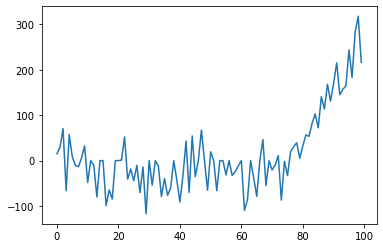

In [17]:
psi_cdf=[]
for i in range(period):
    psimean=-1*np.mean(psi[i,:,:10],0)
    z_min = np.where(psimean==psimean.max())[0][0]
    psi_cdf.append(psimean[:z_min].sum())
plt.plot(psi_cdf)

In [18]:
import scipy.io.wavfile
import scipy.signal

b, a = scipy.signal.butter(3, 0.05)

psi_cdf_sm = scipy.signal.filtfilt(b, a, psi_cdf)

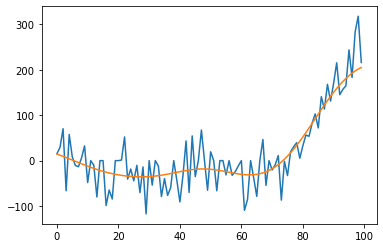

In [19]:
plt.plot(psi_cdf)
plt.plot(psi_cdf_sm)

In [20]:
print('length of psi_cdf',len(psi_cdf))

length of psi_cdf 100


In [21]:
psi01=psi_cdf_sm.copy()
%store psi01

Stored 'psi01' (ndarray)
Stored 'psi01_raw' (list)
